In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string

import matplotlib
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from pymongo import MongoClient
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    plot_roc_curve,
    precision_score,
    recall_score,
    plot_confusion_matrix
)
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
sns.set_theme()
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import plot_roc_curve, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import math


In [2]:
#data = pd.read_json('Movies_and_TV_5.json', lines=True)

In [4]:

from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client['amazon_reviews']
reviews = db['reviews']
reviews_cleaned = db['reviews_cleaned']
balanced_10k = db['balanced_10k']
balanced_40k = db['balanced_40k']

In [5]:
balanced_10k_each = pd.DataFrame(balanced_10k.find({}, {'stemmed': 0}))
balanced_40k_each = pd.DataFrame(balanced_40k.find({}, {'stemmed': 0}))

In [4]:
original_df = pd.DataFrame(reviews_cleaned.find({}, {'stemmed':0}))

In [5]:
df = original_df

In [6]:
df['review_char_length'] = df['reviewText'].apply(len)
df['stars'] = df['overall'].apply(lambda x: int(x))
df = df[(df['review_char_length']>500) & (df['review_char_length'] < 3000)]

In [50]:
#df['reviewerName'].value_counts()

Amazon Customer                          3508
Michael Butts                            2156
Tsuyoshi                                 2121
Grady Harp                               1911
Hiram Gomez Pardo                        1887
                                         ... 
Evigan "d-(O.o)-b"                          1
Jonquil                                     1
Gregory L Leber                             1
Scottiboy "I've seen a movie or two"        1
Amazon Customer "Baghdad Cinemaphile"       1
Name: reviewerName, Length: 67273, dtype: int64

In [7]:
one_star_reviews = df[df['stars'] == 1]
two_star_reviews = df[df['stars'] == 2]
three_star_reviews = df[df['stars'] == 3]
four_star_reviews =df[df['stars'] == 4]
five_star_reviews = df[df['stars'] == 5]

<BarContainer object of 5 artists>

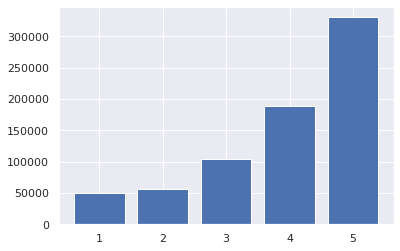

In [17]:
fig, ax = plt.subplots()
ax.bar(df['stars'].value_counts().index,df['overall'].value_counts())

In [14]:
balanced_10k_each = pd.concat([one_star_reviews.iloc[:10000], two_star_reviews.iloc[:10000], three_star_reviews.iloc[:10000], four_star_reviews.iloc[:10000], five_star_reviews.iloc[:10000]])
balanced_40k_each = pd.concat([one_star_reviews.iloc[:40000], two_star_reviews.iloc[:40000], three_star_reviews.iloc[:40000], four_star_reviews.iloc[:40000], five_star_reviews.iloc[:40000]])
balanced_40k_each['stars'].value_counts()

5    40000
4    40000
3    40000
2    40000
1    40000
Name: stars, dtype: int64

In [11]:
import nltk
nltk_stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.RegexpTokenizer(r"\w+")

stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def NLP_cleaner_mongodb(pandas_df, collection, document_column_name = 'reviewText'):
    '''
    takes pandas dataframe and inserts entries into mongodb collection with lemmatized text
    '''
    '''
    df = pandas_df
    df['unicode'] = df[document_column_name].str.encode('ascii', 'ignore').str.decode('ascii')
    df['lower'] = df['unicode'].apply(lambda x: x.lower())
    df['remove_punct'] = df['lower'].apply(lambda x: tokenizer.tokenize(x))
    df['no_stopwords'] = df['remove_punct'].apply(lambda x: remove_stopwords(x))
    df['lemmatized'] = df['no_stopwords'].apply(lambda x: lemmatize_text(tokenize(x)))
    '''
    for row_num in range(pandas_df.shape[0]):
        row = (pandas_df.iloc[row_num])
        unicode = row[document_column_name].encode('ascii', 'ignore').decode('ascii')
        lower = unicode.lower()
        remove_punct = tokenize(lower)
        no_stopwords = remove_stopwords(remove_punct)
        lemmatized = lemmatize_text(tokenize(no_stopwords))
        stemmed = stem_text(tokenize(no_stopwords))
        collection.insert_one({'reviewerID': str(row['reviewerID']), 'asin':str(row['asin']), 'reviewerName':row['reviewerName'], 'reviewText': row['reviewText'], 'helpful':row['helpful'], 'overall':str(row['overall']), 'summary':row['summary'], 'unixReviewTime':str(row['unixReviewTime']), 'reviewTime':row['reviewTime'], 'lemmatized':lemmatized, 'stemmed':stemmed})
    
    
    


In [115]:
#NLP_cleaner_mongodb(df, reviews_cleaned)

In [12]:


def remove_punctuation(comment):
    no_punct = [word for word in comment if word not in string.punctuation]
    return ' '.join(no_punct)

def tokenize(comment):
    token = [word.lower() for word in tokenizer.tokenize(comment)]
    return token

def remove_stopwords(comment):
    no_stops_words = [word for word in comment if word not in nltk_stopwords]
    return ' '.join(no_stops_words)

def stem_text(comment):
    stem = [stemmer.stem(word) for word in comment]
    after_stem = ' '.join(stem)
    return after_stem

def lemmatize_text(comment):
    lemma = [lemmatizer.lemmatize(word) for word in comment]
    after_lemma = ' '.join(lemma)
    return after_lemma


In [22]:
multiNB(balanced_40k_each, 'lemmatized', max_features=20000,max_iter=10000)

((0.50855,
  array([0.54003813, 0.44029076, 0.42734194, 0.46121372, 0.63624145]),
  array([0.68908892, 0.42079147, 0.32559899, 0.44376745, 0.65828066])),
 array([[5665, 1741,  382,  239,  194],
        [2573, 3392, 1302,  552,  242],
        [1075, 1702, 2582, 1862,  709],
        [ 608,  584, 1358, 3496, 1832],
        [ 569,  285,  418, 1431, 5207]]),
 MultinomialNB())

<AxesSubplot:>

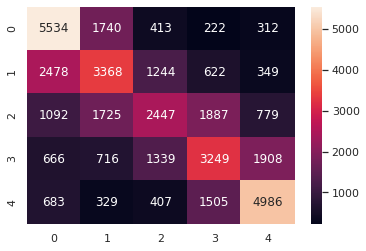

In [37]:
sns.heatmap([[5534, 1740,  413,  222,  312],
        [2478, 3368, 1244,  622,  349],
        [1092, 1725, 2447, 1887,  779],
        [ 666,  716, 1339, 3249, 1908],
        [ 683,  329,  407, 1505, 4986]], annot=True, fmt='g')

In [22]:
tup = rf_test(balanced_10k_each, 'lemmatized', max_depth=15, n_est=400, max_feat = 10000, new_stop_words = ['one', 'two', 'three', 'four', 'five'])
tup

(40000, 10000)


((0.4503, 0.4503, 0.4503),
 array([[1454,  241,  105,   64,  151],
        [ 772,  504,  306,  171,  247],
        [ 374,  303,  518,  426,  403],
        [ 218,   95,  305,  658,  776],
        [ 164,   37,   91,  248, 1369]]),
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                        n_estimators=400),
 <40000x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 3367767 stored elements in Compressed Sparse Row format>)

<AxesSubplot:>

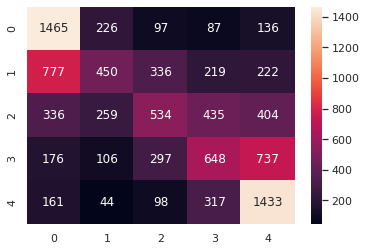

In [28]:
sns.heatmap([[1465,  226,   97,   87,  136],
        [ 777,  450,  336,  219,  222],
        [ 336,  259,  534,  435,  404],
        [ 176,  106,  297,  648,  737],
        [ 161,   44,   98,  317, 1433]], annot=True, fmt='g')

In [17]:
knn_classifier(balanced_10k_each, 'lemmatized')

(0.3619,
 array([[961, 515, 357, 118,  60],
        [707, 643, 396, 189,  69],
        [418, 486, 658, 309,  97],
        [245, 350, 503, 632, 234],
        [164, 211, 372, 581, 725]]))

In [52]:
tup =logreg(balanced_40k_each, 'lemmatized')
tup

((0.511,
  array([0.60002314, 0.46082266, 0.42833653, 0.44747649, 0.58636614]),
  array([0.6515894 , 0.42830283, 0.38851603, 0.42188085, 0.66579276])),
 array([[5186, 1737,  520,  215,  301],
        [2129, 3417, 1537,  527,  368],
        [ 691, 1578, 3126, 1808,  843],
        [ 291,  455, 1633, 3378, 2250],
        [ 346,  228,  482, 1621, 5333]]),
 LogisticRegression(max_iter=2000))

<AxesSubplot:>

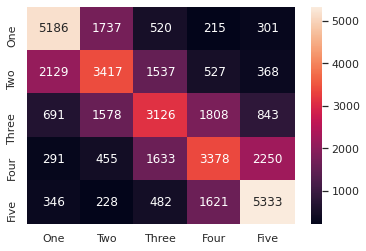

In [48]:
make_heatmap([[5186, 1737,  520,  215,  301],
        [2129, 3417, 1537,  527,  368],
        [ 691, 1578, 3126, 1808,  843],
        [ 291,  455, 1633, 3378, 2250],
        [ 346,  228,  482, 1621, 5333]])

In [ ]:
knn_classifier(balanced_10k_each)

In [6]:
def multiNB(pandas_df, text_column='reviewText', max_features = 1500, max_iter = 2000):

    X = pandas_df[text_column]
    y = pandas_df['overall']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    tvectorizer = CountVectorizer(max_features = max_features, strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b',lowercase=True)
    X_train_tvectorizer = tvectorizer.fit_transform(X_train)
    X_test_tvectorizer = tvectorizer.transform(X_test)


    mnb = MultinomialNB()
    mnb.fit(X_train_tvectorizer, y_train)
    predict = mnb.predict(X_test_tvectorizer)

    a = (accuracy_score(y_test, predict))
    p = (precision_score(y_test, predict, average=None))
    r = (recall_score(y_test, predict, average=None))

    cm = confusion_matrix(y_test, predict)
    
    return (a,p,r), cm, mnb

In [20]:
def rf_test(pandas_df, text_column = 'reviewText', n_est=10, max_depth = 40, max_feat=None, new_stop_words = []):

    X = pandas_df[text_column]
    y = pandas_df['stars']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    tvectorizer = TfidfVectorizer(max_features = max_feat, strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words=stopwords.words('english')+new_stop_words)
    X_train_tvectorizer = tvectorizer.fit_transform(X_train)
    X_test_tvectorizer = tvectorizer.transform(X_test)
    
    print(X_train_tvectorizer.shape)
    
    rf = RandomForestClassifier(n_estimators = n_est, max_depth = max_depth, class_weight='balanced_subsample')
    rf.fit(X_train_tvectorizer, y_train)
    predict = rf.predict(X_test_tvectorizer)
    
    a = (accuracy_score(y_test, predict))
    p = (precision_score(y_test, predict, average='micro'))
    r = (recall_score(y_test, predict, average='micro'))

    cm = confusion_matrix(y_test, predict)
    return (a,p,r), cm, rf, X_train_tvectorizer


In [21]:
def knn_classifier(pandas_df, text_column = 'reviewText'):
    
    X = pandas_df[text_column]
    y = pandas_df['stars']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    tvectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w\w+\b', stop_words=stopwords.words('english'))
    X_train_tvectorizer = tvectorizer.fit_transform(X_train)
    X_test_tvectorizer = tvectorizer.transform(X_test)
    
    knn = KNeighborsClassifier(n_neighbors = 30).fit(X_train_tvectorizer, y_train)
    accuracy = knn.score(X_test_tvectorizer, y_test)
    
    knn_predictions = knn.predict(X_test_tvectorizer) 
    cm = confusion_matrix(y_test, knn_predictions)
    
    return accuracy, cm

In [9]:
def logreg(pandas_df, text_column = 'reviewText', max_features=1500, max_iter=2000):

    X = pandas_df[text_column]
    y = pandas_df['stars']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    tvectorizer = TfidfVectorizer(max_features = max_features, strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b')
    X_train_tvectorizer = tvectorizer.fit_transform(X_train)
    X_test_tvectorizer = tvectorizer.transform(X_test)

    lr = LogisticRegression(max_iter=max_iter)
    lr.fit(X_train_tvectorizer, y_train)
    predict = lr.predict(X_test_tvectorizer)

    a = (accuracy_score(y_test, predict))
    p = (precision_score(y_test, predict, average=None))
    r = (recall_score(y_test, predict, average=None))
    cm = confusion_matrix(y_test, predict)
    return ((a,p,r),cm,lr)

In [10]:
def make_heatmap(cm):
    categories = ['One', 'Two', 'Three', 'Four', 'Five']
    
    return sns.heatmap(cm, annot=True, fmt='g', xticklabels = categories, yticklabels = categories)

In [11]:
def tdif_most_important_values_for_random_forest(tdif_vectorizer, fit_random_forest):    
    d= {}
    rf = fit_random_forest
    for imp,word in zip(list(rf.feature_importances_),tdif_vectorizer.get_feature_names()):
        d[word] = imp
    sorted_values = list(reversed(sorted(d.values()))) # Sort the values
    sorted_dict = {}
    for i in sorted_values:
        for k in d.keys():
            if d[k] == i:
                sorted_dict[k] = d[k]
                break
    return sorted_dict

In [75]:
#test
tup[3]

TfidfVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents='ascii')

In [48]:
dense_matrix = tup[3].todense()

In [51]:
dense_matrix.shape

(40000, 10000)

In [20]:
pandas_df = balanced_40k_each
X = pandas_df['lemmatized']
y = pandas_df['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
tvectorizer = TfidfVectorizer(max_features = 1500, strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words=stopwords.words('english')+['one', 'two', 'three' ,'four', 'five', 'movie', 'film', 'quot'])
X_train_tvectorizer = tvectorizer.fit_transform(X_train)
X_test_tvectorizer = tvectorizer.transform(X_test)
    
print(X_train_tvectorizer.shape)
    
rf = RandomForestClassifier(n_estimators = 400, max_depth = 15, class_weight='balanced_subsample')
rf.fit(X_train_tvectorizer, y_train)
predict = rf.predict(X_test_tvectorizer)

a = (accuracy_score(y_test, predict))
p = (precision_score(y_test, predict, average=None))
r = (recall_score(y_test, predict, average=None))

cm = confusion_matrix(y_test, predict)
(a,p,r), cm, rf, X_train_tvectorizer


(160000, 1500)


((0.432325,
  array([0.49784765, 0.40909091, 0.36837261, 0.35889021, 0.45547709]),
  array([0.66842568, 0.28540988, 0.248695  , 0.30048707, 0.66029963])),
 array([[5320, 1188,  450,  364,  637],
        [2835, 2277, 1234,  762,  870],
        [1294, 1345, 2001, 1792, 1614],
        [ 642,  514, 1243, 2406, 3202],
        [ 595,  242,  504, 1380, 5289]]),
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                        n_estimators=400),
 <160000x1500 sparse matrix of type '<class 'numpy.float64'>'
 	with 9412484 stored elements in Compressed Sparse Row format>)

In [21]:
dense_matrix = X_train_tvectorizer.todense()
feature_names = tvectorizer.get_feature_names()
sums = np.average(dense_matrix, axis=0)
sums = sums.tolist()[0]
import operator
feature_dictionary = {}
for k, v in zip(feature_names, sums):
    feature_dictionary[k] = v

sorted_d = dict(sorted(feature_dictionary.items(), key=operator.itemgetter(1), reverse=True))
sorted_d

{'like': 0.0339126385418547,
 'good': 0.030097281869872785,
 'time': 0.02915974693245386,
 'story': 0.026608358122323067,
 'character': 0.02630795361850332,
 'get': 0.025784069473977548,
 'dvd': 0.02503383285280097,
 'would': 0.024928119089489977,
 'scene': 0.024673190195376758,
 'great': 0.02434490702627554,
 'really': 0.023801075848605063,
 'make': 0.02325008228568807,
 'even': 0.02312909425338322,
 'see': 0.02292813177278491,
 'well': 0.022647604109507807,
 'much': 0.02231394975213064,
 'first': 0.021452608186541305,
 'bad': 0.019270536086022416,
 'way': 0.01905694105833673,
 'also': 0.01903705326411724,
 'people': 0.019002274658757885,
 'star': 0.018367694977924662,
 'love': 0.01834931873218069,
 'thing': 0.01812964884615173,
 'best': 0.017952435686752182,
 'watch': 0.017666665389461163,
 'could': 0.017658142853583577,
 'think': 0.017540525872758526,
 'made': 0.017530338528060335,
 'life': 0.0174218977406577,
 'better': 0.01732835543944827,
 'many': 0.017238528219998113,
 'year': 0

{'movie': 0.05368510604067714,
 'film': 0.046703850810812006,
 'quot': 0.03360110637246211,
 'like': 0.02326586066262509,
 'good': 0.020860164849875205,
 'time': 0.020077129074140748,
 'dvd': 0.018693977653676756,
 'story': 0.018160728308046884,
 'character': 0.017675311713946384,
 'get': 0.01740685860276381,
 'scene': 0.017285172557545084,
 'would': 0.017161173407424565,
 'great': 0.017010057967531928,
 'really': 0.016466425452646663,
 'see': 0.016023755770740923,
 'make': 0.015859943577551845,
 'even': 0.015808194461465575,
 'well': 0.01563983805381292,
 'much': 0.015355219902473873,
 'first': 0.01473267920912816,
 'version': 0.01353959505739131,
 'people': 0.013290404692996222,
 'bad': 0.013215914244637606,
 'also': 0.01319128468274956,
 'way': 0.013141328721699565,
 'love': 0.012659433329682033,
 'thing': 0.012652580261641707,
 'think': 0.012589839307874806,
 'star': 0.012519221456099012,
 'watch': 0.012516714803089064,
 'many': 0.012204541132389522,
 'could': 0.012135393131152123,

In [ ]:
#change boostrap sample size in random forest

In [47]:
def ROC(predict, X_test_tvectorizer, y_test):
    
    Predicted = predict
    Predicted_prob = lr.predict_proba(X_test_tvectorizer)
    fig, axs = plt.subplots(1,2, figsize=(18.75,10))
    y_test_dummy = pd.get_dummies(y_test).values
    targets = ['One star', 'Two stars', 'Three stars', 'Four stars', 'Five stars']
    for i in range(5):
        # ROC Curve
        fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],Predicted_prob[:,i])
        axs[0].plot(fpr,tpr,lw=3,label=targets[i])#,color=colors[i])
        axs[0].plot([0,1],[0,1],color='k',ls='--')
        axs[0].set_xlabel('False Positive Rate')
        axs[0].set_ylabel('True Positive Rate')
        axs[0].legend()
        axs[0].set_title('ROC Curve')
        # Precision-Recall Curve
        precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],Predicted_prob[:,i])
        axs[1].plot(recall,precision,label=targets[i])#,color=colors[i])
        axs[1].set_xlabel('Recall')
        axs[1].set_ylabel('Precision')
        axs[1].set_title('Precision-Recall Curve')
        axs[1].legend() 

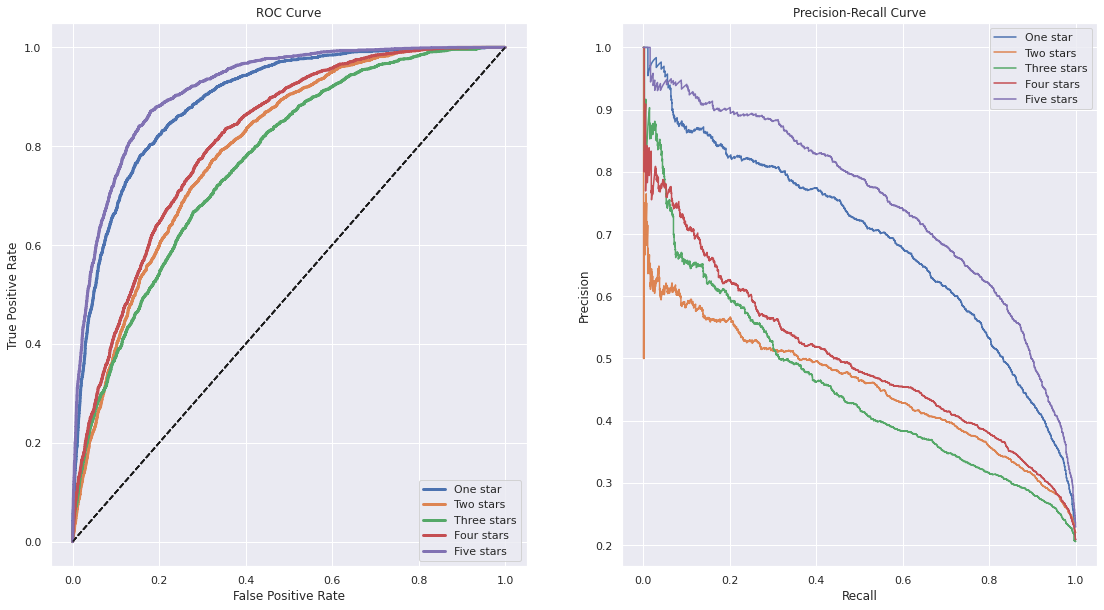

In [48]:
ROC(predict, X_test_tvectorizer, y_test)

# LOGREG

In [12]:
    #pandas_df, text_column = 'reviewText', max_features=1500, max_iter=2000:
    pandas_df = balanced_10k_each
    X = pandas_df['lemmatized']
    y = pandas_df['stars']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    tvectorizer = TfidfVectorizer(max_features = 1500, strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words = ['one', 'two', 'three', 'four', 'five'], ngram_range = (1,2))
    X_train_tvectorizer = tvectorizer.fit_transform(X_train)
    X_test_tvectorizer = tvectorizer.transform(X_test)

    lr = LogisticRegression(max_iter=3000)
    lr.fit(X_train_tvectorizer, y_train)
    predict = lr.predict(X_test_tvectorizer)
    
    #train score
    print(f'Train score: {lr.score(X_train_tvectorizer, y_train)}')
    
    a = (accuracy_score(y_test, predict))
    p = (precision_score(y_test, predict, average=None))
    r = (recall_score(y_test, predict, average=None))
    cm = confusion_matrix(y_test, predict)
    ((a,p,r),cm,lr)

Train score: 0.5617


((0.494,
  array([0.58341014, 0.42419175, 0.40898618, 0.42857143, 0.59021544]),
  array([0.62953754, 0.37974052, 0.36077236, 0.45213849, 0.64052606])),
 array([[1266,  444,  120,   79,  102],
        [ 533,  761,  408,  175,  127],
        [ 188,  379,  710,  493,  198],
        [  89,  137,  364,  888,  486],
        [  94,   73,  134,  437, 1315]]),
 LogisticRegression(max_iter=3000))

In [19]:
def logreg_coef_importance(fit_logreg, tvectorizer):
    feature_names = tvectorizer.get_feature_names()
    coef_matrix = lr.coef_
    dict_list = []
    for coef_row in coef_matrix:
        print(coef_row)
        d = {}
        for coef, feature_name in zip(coef_row, feature_names):
            d[feature_name] = coef
    
        sorted_values = list(reversed(sorted(d.values()))) # Sort the values
        sorted_dict = {}
        for i in sorted_values:
            for k in d.keys():
                if d[k] == i:
                    sorted_dict[k] = d[k]
                    break
        dict_list.append(sorted_dict)
        
    return dict_list

def top_x_features_per_star(dictionary_list, num, remove_duplicates = True):
    '''
    Takes list of dictionaries created by logreg_coef_importance and
    removes duplicates up until the up_until value
    
    '''
    for dictionary in dictionary_list:
        
        pass
        
    
        
        
        
dicts = logreg_coef_importance(lr, tvectorizer)
dicts[2]

[ 0.27750371  0.04439016  0.77317318 ... -0.91776902 -0.64463376
  1.79919672]
[-0.50804817 -0.02103613 -0.35948348 ... -0.31628365 -0.35300664
 -0.0793503 ]
[-0.42156375 -0.32842727 -0.76745481 ...  0.30389121  0.70774741
 -1.2846948 ]
[ 0.13929213 -0.47394513  0.22825972 ... -0.00982815 -0.12178043
 -0.16210439]
[ 0.51281607  0.77901838  0.12550539 ...  0.93998961  0.41167342
 -0.27304723]


{'average': 2.404514939778333,
 'still': 2.2223526894931718,
 'however': 2.1449163259071096,
 'decent': 2.0789179133189504,
 'though': 2.0705385870474395,
 'somewhat': 1.99846703019271,
 'ok': 1.8712814980277839,
 'okay': 1.8641392029463157,
 'fun': 1.8325038356849659,
 'rather': 1.7707191894626702,
 'little': 1.7519834476181044,
 'cruise': 1.7504276911984638,
 'enjoyable': 1.7256297861289014,
 'expect': 1.6999227637570036,
 'entertaining': 1.6933543653118048,
 'pretty good': 1.665873793146294,
 'batman': 1.6495219231407288,
 'worth': 1.633977836003617,
 'overall': 1.621974449352152,
 'decide': 1.5797475508931071,
 'certainly': 1.5632873132495786,
 'moment': 1.5257073479799956,
 'half': 1.5244198190398193,
 'expected': 1.4985907847147482,
 'problem': 1.48070829842949,
 'amusing': 1.4698654940337328,
 'cute': 1.4354758723477077,
 'seems': 1.4297140071527559,
 'predictable': 1.4210963025929595,
 'good': 1.4037343376651044,
 'said': 1.4022038913961516,
 'film also': 1.3997816105246939,
 '

In [123]:
pd.DataFrame(lr.coef_)

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,0.292650,0.037851,0.795832,-0.830617,0.400703,-0.302286,-0.385230,-0.188002,0.029432,-0.604274,...,-0.086623,0.326309,-0.266515,-0.114782,-0.505645,-0.706767,-0.490034,-0.834480,-0.650206,1.741464
1,-0.510900,-0.013342,-0.384948,0.343298,-0.173422,0.274714,0.663714,-0.056118,0.848901,0.312343,...,-0.742723,0.024349,0.710888,0.168055,-0.140135,-0.689513,0.074902,-0.316224,-0.393700,-0.054191
2,-0.430217,-0.328359,-0.761752,0.748394,0.060474,0.037558,0.291402,0.243693,0.163568,0.684565,...,-0.306468,0.029556,0.275686,0.177901,0.171525,-0.096741,0.494281,0.273037,0.695664,-1.256201
3,0.116329,-0.484678,0.218897,-0.248157,-0.449232,-0.329005,-0.428748,-0.235029,-0.475578,-0.588896,...,0.923303,-0.076502,-0.184823,-0.791578,0.032707,0.599507,-0.160044,-0.028032,-0.065715,-0.171251
4,0.532138,0.788527,0.131971,-0.012918,0.161478,0.319020,-0.141137,0.235455,-0.566322,0.196262,...,0.212511,-0.303712,-0.535237,0.560403,0.441548,0.893513,0.080894,0.905700,0.413958,-0.259821


# using stars as numerical

In [98]:
regressor = DecisionTreeRegressor(random_state=0, max_depth = 20).fit(X_train_tvectorizer, y_train)
y = y.apply(lambda x: float(x))
mean_squared_error
cross_val_score(regressor, X_test_tvectorizer, y_test, cv=5).mean()

KeyboardInterrupt: 

In [99]:
print(f'Train RMSE: {(-cross_val_score(dt,X_test_tvectorizer,y_test,scoring="neg_root_mean_squared_error")).mean()}') 

Train RMSE: 1.6334331382121874


In [90]:
dt = DecisionTreeRegressor(random_state=0, max_depth = 45, max_features=10000)
dt.fit(X_train_tvectorizer, y_train)
dt_pred = dt.predict(X_test_tvectorizer)
#transform dt_pred to categorical
dt_pred = pd.Series(dt_pred).apply(lambda x: math.floor(x+.5))

(array([1702.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 2120.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 2244.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 2399.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 1535.]),
 array([1.  , 1.08, 1.16, 1.24, 1.32, 1.4 , 1.48, 1.56, 1.64, 1.72, 1.8 ,
        1.88, 1.96, 2.04, 2.12, 2.2 , 2.28, 2.36, 2.44, 2.52, 2.6 , 2.68,
        2.76, 2.84, 2.92, 3.  , 3.08, 3.16, 3.24, 3.32, 3.4 , 3.48, 3.56,
        3.64, 3.72, 3.8 , 3.88, 3.96, 4.04, 4.12, 4.2 , 4.28, 4.36, 4.44,
        4.52, 4.6 , 4.68, 4.76, 4.84, 4.92, 5.  ]),
 <BarContainer object of 50 artists>)

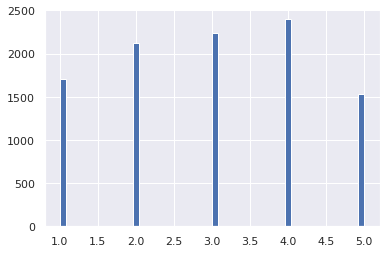

In [91]:
fig, ax = plt.subplots()
ax.hist(dt_pred, bins=50)

In [92]:
for t,p in zip(y_test, dt_pred):
    print(t,p)

3 4
3 2
5 5
1 5
1 4
5 3
1 2
1 5
2 1
5 4
3 4
5 5
1 1
4 3
5 4
4 4
1 1
2 4
1 2
2 4
2 2
3 4
5 5
2 3
1 1
5 2
1 1
4 4
4 4
3 2
4 3
3 3
5 3
1 4
1 3
4 4
1 1
3 4
1 3
3 5
5 1
1 3
2 2
5 5
3 4
3 3
2 4
5 1
1 1
3 3
3 2
1 1
5 2
1 3
1 3
3 4
3 2
1 3
4 3
3 3
4 4
3 5
2 3
4 3
5 4
4 5
5 2
1 5
4 4
2 1
4 3
2 2
4 2
4 5
3 4
2 5
5 4
2 3
4 4
3 4
2 3
3 2
1 4
4 4
3 1
4 3
3 2
2 2
3 4
2 5
5 4
3 4
4 1
1 1
2 3
3 4
3 4
2 4
5 5
1 1
2 1
3 3
5 1
3 2
2 3
4 2
3 2
2 2
2 3
3 4
5 5
1 2
5 4
3 4
1 1
1 4
4 5
2 4
3 3
2 3
2 1
4 4
5 5
2 1
1 4
2 2
3 3
1 2
5 4
4 3
5 5
2 2
5 4
1 1
5 3
1 2
3 3
3 4
4 3
5 4
2 5
1 1
5 1
3 4
4 2
5 2
1 4
2 1
5 4
3 2
4 3
3 3
4 2
2 4
1 5
3 2
2 3
1 1
4 3
2 1
1 2
4 1
4 2
2 3
3 2
3 3
5 3
4 3
3 4
1 1
3 4
4 4
5 4
2 2
1 2
4 3
1 4
3 3
4 2
1 2
4 1
1 4
1 2
3 3
3 2
5 5
5 2
4 4
3 2
2 4
5 4
5 4
2 2
2 5
3 4
1 3
1 2
2 1
4 4
5 5
2 3
1 5
5 4
4 5
4 4
4 2
5 5
4 2
5 4
4 4
3 1
3 3
2 4
1 2
3 3
4 4
5 1
5 4
2 5
5 3
5 5
2 1
5 4
2 3
5 4
3 4
5 4
2 5
3 5
1 1
5 5
3 3
5 2
1 4
3 3
1 2
2 2
1 1
1 1
1 2
1 1
1 1
5 5
4 5
3 3
4 1
2 2
5 4
2 2
3 1


3 5
1 4
5 3
3 4
4 4
5 3
1 2
3 1
2 4
1 1
2 5
4 3
4 3
1 4
4 4
5 1
5 5
2 1
1 2
4 3
4 1
2 1
3 3
4 3
4 1
3 2
2 4
3 2
5 5
2 3
5 5
4 2
4 5
5 2
2 3
5 3
5 3
1 1
5 3
3 5
1 4
5 2
5 3
4 2
3 5
5 3
1 5
5 4
1 1
4 3
1 1
3 2
3 2
3 2
1 1
2 3
5 5
2 1
5 4
3 4
5 3
3 3
3 2
1 1
3 1
2 4
5 3
5 3
3 4
3 3
1 3
2 3
1 1
4 5
1 1
3 3
2 4
1 4
5 4
4 5
1 1
5 3
5 2
3 3
1 1
4 4
3 1
2 1
5 5
2 2
2 1
5 4
1 3
3 3
1 1
2 3
2 2
2 4
1 1
5 4
4 2
2 2
4 3
1 3
5 5
5 3
1 4
5 5
3 3
3 3
3 1
3 4
4 5
5 3
2 5
4 2
4 4
3 3
2 3
2 1
2 1
3 5
4 2
1 1
4 2
5 3
1 1
1 3
2 4
4 4
4 2
4 1
1 1
2 3
5 5
1 1
3 3
1 1
5 2
4 3
5 4
2 1
4 4
1 1
1 5
3 5
4 5
4 3
3 2
5 3
5 5
3 2
5 5
1 1
3 3
5 4
1 4
3 1
1 2
2 2
4 4
4 1
1 2
5 2
3 5
1 2
1 1
5 1
1 1
3 4
1 1
2 1
2 2
5 2
4 4
1 1
3 2
4 4
2 1
1 2
1 3
5 4
2 2
3 3
2 3
2 2
2 2
2 1
1 1
4 4
1 4
4 4
2 2
2 2
5 4
1 1
2 1
3 3
5 5
5 2
2 1
1 4
5 4
4 5
2 1
3 1
3 4
1 3
5 2
1 1
3 4
3 4
5 3
2 5
2 2
5 4
3 1
2 2
1 3
3 2
2 3
2 2
5 5
1 2
3 3
5 3
3 4
4 5
2 1
2 5
2 5
3 4
3 2
4 3
1 2
2 1
4 5
3 1
1 4
4 4
5 2
1 3
4 3
4 3
2 1
2 2
2 3
1 2
1 1
1 1


4 3
2 2
3 2
4 2
5 5
1 2
4 1
3 4
5 5
1 2
4 3
4 1
3 4
3 5
2 2
3 5
2 4
1 1
4 1
2 5
2 4
2 3
4 4
2 3
3 2
2 2
3 3
5 5
4 4
4 3
2 1
2 2
5 5
4 3
1 5
3 4
5 2
3 1
4 4
2 1
2 5
1 1
5 3
4 5
4 3
1 4
1 3
2 4
2 2
2 3
4 3
1 4
1 2
2 4
4 4
2 1
2 3
5 4
4 4
5 5
1 1
4 5
5 4
5 5
1 1
4 4
3 2
5 1
1 3
1 1
3 5
4 1
5 5
4 2
1 1
4 4
1 3
3 1
2 3
5 5
4 4
3 3
5 5
4 3
4 1
3 3
5 5
1 2
4 1
1 3
2 5
3 1
2 1
1 5
1 2
3 3
2 4
2 1
3 5
2 2
4 4
5 3
3 3
4 5
4 2
2 1
3 3
4 4
2 1
2 2
1 2
1 4
4 4
2 2
3 2
2 2
2 3
2 5
4 4
2 1
5 3
2 3
5 1
4 2
2 3
4 3
3 4
1 3
2 1
3 2
1 1
5 4
2 3
1 3
1 1
4 3
3 4
4 3
4 4
2 2
3 2
1 1
5 5
2 4
3 2
2 2
5 1
4 3
4 4
5 4
5 4
4 5
4 4
2 4
5 2
3 3
1 1
3 1
2 1
1 2
5 3
2 5
2 3
1 1
3 3
5 4
2 4
3 2
2 2
5 1
3 3
5 4
2 1
2 1
1 5
1 2
4 3
4 3
5 4
1 2
1 3
4 4
3 3
1 2
4 2
5 2
3 5
1 5
3 2
1 1
1 2
1 1
5 4
4 4
4 1
3 5
2 2
2 2
1 2
4 4
2 5
3 2
2 4
4 4
5 2
5 3
2 1
1 2
4 4
2 3
2 3
2 2
1 3
1 2
3 5
3 5
1 3
5 2
5 4
3 5
4 4
3 2
1 3
4 2
4 2
5 4
3 4
5 4
3 4
2 5
5 4
3 4
3 2
3 4
4 4
2 2
4 3
1 1
1 5
1 4
5 5
2 1
5 4
5 3
4 2
2 2
1 1
1 1
2 4
1 2


3 4
1 5
4 4
1 1
5 4
3 4
5 5
5 3
4 5
1 1
3 4
5 3
2 2
4 5
3 2
4 3
4 4
5 5
2 4
1 1
2 2
1 2
4 2
3 2
4 5
5 3
3 5
3 3
1 4
3 4
3 4
5 5
4 3
4 4
3 4
3 2
3 4
2 1
3 3
4 4
1 3
2 3
1 3
1 1
1 2
2 3
4 3
5 4
2 3
5 5
1 2
2 3
2 3
3 5
1 3
3 5
1 3
4 3
2 5
3 3
1 1
3 2
5 5
5 1
1 3
4 4
2 1
3 2
4 4
5 3
5 3
4 5
2 5
2 3
2 4
2 1
4 1
5 4
5 4
2 4
5 5
4 3
4 3
1 1
2 1
1 1
2 2
4 3
5 4
4 5
2 2
4 3
3 4
4 2
4 3
3 4
1 1
2 5
2 4
5 3
2 5
1 4
5 5
2 2
4 3
3 4
2 2
2 4
5 4
1 2
2 2
2 1
1 3
4 2
1 2
1 3
2 3
4 4
4 3
2 2
2 1
4 2
4 4
3 5
3 5
1 1
4 2
4 5
5 5
1 1
2 4
1 3
4 3
1 2
2 2
5 5
5 5
1 1
1 1
4 3
1 2
4 5
1 2
5 2
1 3
2 3
3 2
2 5
5 4
5 4
1 1
3 1
5 2
3 3
2 3
1 1
3 5
1 4
4 3
2 2
3 3
2 3
5 3
5 4
3 4
1 4
4 5
3 2
1 5
2 2
2 2
5 4
3 1
3 4
4 2
2 4
2 4
4 4
5 3
1 1
4 3
4 3
4 3
3 4
3 1
5 3
2 3
3 5
4 4
4 2
2 1
2 1
3 3
4 2
2 3
1 3
1 1
4 3
4 4
4 4
1 4
1 1
5 5
3 3
1 2
4 3
1 3
2 5
1 2
1 1
3 1
3 4
4 3
5 5
1 2
3 3
5 3
2 2
5 2
3 4
5 5
5 1
4 3
4 5
2 3
5 5
2 5
4 1
5 4
4 2
2 1
5 3
3 2
4 4
1 2
3 5
2 5
4 4
4 1
1 2
1 1
5 3
4 5
2 2
2 2
1 4
1 1
5 3
3 4
1 4


In [ ]:
#get gini importance for random forest
